# Importing required libraries

In [157]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, make_scorer

# Reading data

In [158]:
customers = pd.read_csv("customers.csv")
transactions = pd.read_csv("transactions.csv")
geo =pd.read_csv("geo.csv")
print(customers.shape)
print(transactions.shape)
print(geo.shape)

(8452, 8)
(26151, 23)
(46, 4)


In [159]:
customers.head() 

,CUSTOMER,REV_CURRENT_YEAR,REV_CURRENT_YEAR.1,REV_CURRENT_YEAR.2,CREATION_YEAR,OWNERSHIP,COUNTRY,CURRENCY
0,579,"""157832.813953488""",157832.813953,174585.011628,01/01/2003,Privately Owned/Publicly Traded,Switzerland,US Dollar
1,1656,"""0""",0.000000,872.093023,01.01.2004,Privately Owned/Publicly Traded,Switzerland,US Dollar
2,2881,"""43377.9""",43377.900000,2097.670000,01/01/2004,Privately Owned/Publicly Traded,Switzerland,Euro
3,2492,"""82989.85""",82989.850000,83251.950000,01.01.2003,Privately Owned/Publicly Traded,Switzerland,Euro
4,2391,"""148.011627906977""",148.011628,3601.232558,01/01/2003,Governmental,Switzerland,US Dollar


In [160]:
customers.REV_CURRENT_YEAR = customers.REV_CURRENT_YEAR.str.strip("\"").replace('',np.nan).astype('float64')
customers["Rev_diff_check"] = customers["REV_CURRENT_YEAR"]-customers["REV_CURRENT_YEAR.1"]
customers.loc[customers["Rev_diff_check"]>=1]

,CUSTOMER,REV_CURRENT_YEAR,REV_CURRENT_YEAR.1,REV_CURRENT_YEAR.2,CREATION_YEAR,OWNERSHIP,COUNTRY,CURRENCY,Rev_diff_check


In [161]:
customers.drop('Rev_diff_check', axis=1, inplace=True)

In [162]:
def findMissing(df):
    for col in df:
          print(col +': '+ str(df[col].isna().sum()))
findMissing(customers)
#findMissing(transactions)
#findMissing(geo)

CUSTOMER: 0
REV_CURRENT_YEAR: 0
REV_CURRENT_YEAR.1: 0
REV_CURRENT_YEAR.2: 0
CREATION_YEAR: 0
OWNERSHIP: 0
COUNTRY: 0
CURRENCY: 0


# Feature Engineering for customers table

In [163]:
def myDateConv(tt):
    sep = tt[2]
    if sep == '/':
        return pd.to_datetime(tt, format='%d/%m/%Y')
    elif sep == '.':
        return pd.to_datetime(tt, format='%d.%m.%Y')
    else:
        return tt

customers.CREATION_YEAR = customers.CREATION_YEAR.apply(myDateConv)

customers['CREATION_YEAR']=customers['CREATION_YEAR'].dt.year
customers['CHANGE_IN_REV']=customers['REV_CURRENT_YEAR']-customers['REV_CURRENT_YEAR.2']
customers['CHANGE_IN_REV_RELATIVE']=customers['CHANGE_IN_REV']/(customers['REV_CURRENT_YEAR.2']+1)
customers['CUST_AGE']=2021-customers['CREATION_YEAR']

country_dict={'Switzerland':'CH', 'France':'FR'}
customers.COUNTRY=customers.COUNTRY.map(country_dict)

dict= {'Pound Sterling':1.1248, 'Euro':1, 'US Dollar':0.877, 'Chinese Yuan':0.127} #avg conversion rate for 2020
customers['currency_in_euro'] = customers['CURRENCY'].map(dict)
customers['REV_CURRENT_YEAR.1_EURO']=customers['REV_CURRENT_YEAR.1']*customers['currency_in_euro']

In [164]:
customers['Avg_Revenue']=customers[["REV_CURRENT_YEAR", "REV_CURRENT_YEAR.1_EURO", "REV_CURRENT_YEAR.2"]].mean(axis=1)

In [165]:
customers.groupby(customers['COUNTRY'])['CUSTOMER'].count()

COUNTRY
CH    5200
FR    3252
Name: CUSTOMER, dtype: int64

In [166]:
customers.groupby(customers['COUNTRY']).mean()

,CUSTOMER,REV_CURRENT_YEAR,REV_CURRENT_YEAR.1,REV_CURRENT_YEAR.2,CREATION_YEAR,CHANGE_IN_REV,CHANGE_IN_REV_RELATIVE,CUST_AGE,currency_in_euro,REV_CURRENT_YEAR.1_EURO,Avg_Revenue
COUNTRY,,,,,,,,,,,
CH,3085.012500,165151.994152,165151.994152,165007.117896,2006.808269,144.876256,3881.673524,14.191731,0.787219,59897.782645,130018.964898
FR,1705.963715,121304.207964,121304.207964,132392.601698,2008.287515,-11088.393734,3280.963425,12.712485,0.790457,47668.869395,100455.226352


C:\Users\Divya\anaconda3\envs\i2dl\lib\site-packages\matplotlib\cbook\__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


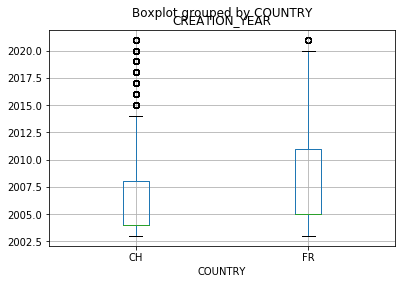

In [20]:
# fig, ax = plt.subplots(figsize=(20,20))
customers.boxplot("CREATION_YEAR",by='COUNTRY')

C:\Users\Divya\anaconda3\envs\i2dl\lib\site-packages\pandas\plotting\_matplotlib\boxplot.py:405: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,
C:\Users\Divya\anaconda3\envs\i2dl\lib\site-packages\matplotlib\cbook\__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
C:\Users\Divya\anaconda3\envs\i2dl\lib\site-packages\matplotlib\cbook\__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleas

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002DA5CE39E08>,
      dtype=object)

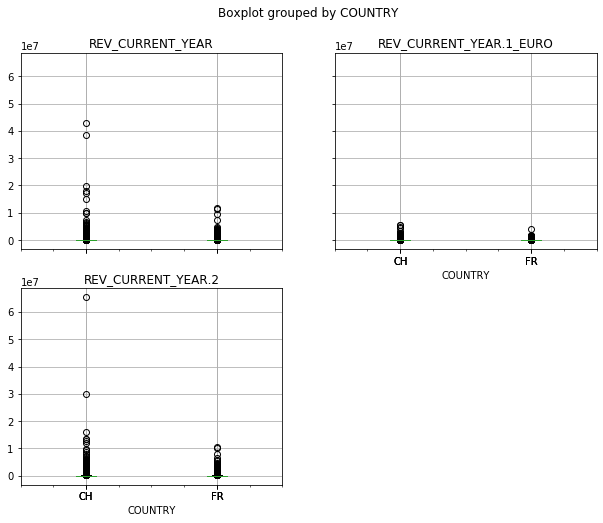

In [71]:
fig, ax = plt.subplots(figsize=(10,8))
customers.boxplot(["REV_CURRENT_YEAR","REV_CURRENT_YEAR.1_EURO","REV_CURRENT_YEAR.2"],by='COUNTRY', ax=ax)

# Feature Engineering for transactions table

In [167]:
transactions.head()

,MO_ID,SO_ID,CUSTOMER,END_CUSTOMER,OFFER_PRICE,SERVICE_LIST_PRICE,MATERIAL_COST,SERVICE_COST,PRICE_LIST,ISIC,...,OFFER_TYPE,BUSINESS_TYPE,COSTS_PRODUCT_A,COSTS_PRODUCT_B,COSTS_PRODUCT_C,OFFER_STATUS,COSTS_PRODUCT_D,COSTS_PRODUCT_E,SALES_LOCATION,TEST_SET_ID
0,a050N000013fnfrQAA,a030N00001EochoQAB,"""1""",NaN,1711.0,1395.0,1107.0,186.30,SFT Standard,2100.0,...,IN,E,0.0,59.48,0.00,LOsT,0.0,0.0,Luzern Central,NaN
1,a050N000013fgL1QAI,a030N00001EociNQAR,"""2""",NaN,26687.6,14651.0,9282.0,7768.34,CMT Installer,7110.0,...,D,N,0.0,0.00,0.00,Lost,0.0,0.0,Zürich East,NaN
2,a050N000013fnwdQAA,a030N00001Eod9yQAB,"""3""",NaN,6264.7,2296.0,1722.0,2168.56,SFT Standard,6820.0,...,FIR,E,0.0,0.00,0.00,WIN,0.0,0.0,Luzern Central,NaN
3,a050N000013foAGQAY,a030N00001EodLEQAZ,"""4""",4,4300.2,310.0,246.0,2775.92,SFT Standard,3821.0,...,FIR,M,0.0,0.00,0.00,Win,0.0,0.0,Basel Central,NaN
4,a050N000013foKVQAY,a030N00001EoeBiQAJ,"""5""",NaN,13693.0,5815.0,4674.0,4179.38,SFT Standard,4719.0,...,FIR,E,0.0,0.00,1854.01,WIN,0.0,0.0,Geneva West,NaN


In [168]:
findMissing(transactions) 
# => 23575: train size
# => 2576: test size
#     sales_location: 37 missing
#     isic: 1675 missing

MO_ID: 0
SO_ID: 0
CUSTOMER: 0
END_CUSTOMER: 20114
OFFER_PRICE: 0
SERVICE_LIST_PRICE: 0
MATERIAL_COST: 0
SERVICE_COST: 0
PRICE_LIST: 0
ISIC: 1675
MO_CREATED_DATE: 0
SO_CREATED_DATE: 0
TECH: 0
OFFER_TYPE: 0
BUSINESS_TYPE: 0
COSTS_PRODUCT_A: 0
COSTS_PRODUCT_B: 0
COSTS_PRODUCT_C: 0
OFFER_STATUS: 2576
COSTS_PRODUCT_D: 0
COSTS_PRODUCT_E: 0
SALES_LOCATION: 37
TEST_SET_ID: 23575


In [169]:
transactions.SALES_LOCATION.unique()

array(['Luzern Central', 'Zürich East', 'Basel Central', 'Geneva West',
       'Lausanne West', 'Sion West', 'St. Gallen East', 'St. Blaise West',
       'Steinhausen Central', 'Bern Central', 'Lausanne East',
       'Granges-Paccot West', 'Ticino Central', 'Lausanne EPS',
       'Zürich EPS', 'Bern EPS', nan, 'Steinhausen East',
       'Velizy Grand Paris', 'Pau Sud Ouest', 'Lille Nord FR',
       'Brest Ouest', 'BesanÃ§on Centre-Est', 'Metz Grand Est',
       'Clermont Centre-Est', 'Bezons Grand Paris', 'Toulouse Sud Ouest',
       'Nice Sud-Est', 'Nantes Ouest', 'Aix Sud-Est',
       'Bordeaux Sud Ouest', 'Rouen Nord FR', 'Grenoble Centre-Est',
       'Tours Ouest', 'Strasbourg Grand Est', 'Dijon Centre-Est',
       'Export Grand Paris', 'Lyon Centre-Est',
       'Vertical Market Enterprise Business France',
       'Montpellier Sud Ouest', 'Poitiers Sud Ouest', 'Limoges Sud Ouest',
       'Others Functions Enterprise Business France', 'Monaco Sud-Est',
       'NA Grand Paris', 'Veli

In [170]:
transactions['MO_CREATED_DATE'] =  pd.to_datetime(transactions['MO_CREATED_DATE'], infer_datetime_format=True)
transactions['SO_CREATED_DATE'] =  pd.to_datetime(transactions['SO_CREATED_DATE'], infer_datetime_format=True)
transactions['Time_Elapsed']=(transactions.MO_CREATED_DATE - transactions.SO_CREATED_DATE).dt.total_seconds()
transactions["CUSTOMER"]=transactions["CUSTOMER"].replace('"', '', regex=True)
dict = {"lose": "0", "lost": "0", "win": 1, "won": 1}
transactions['OFFER_STATUS'] = transactions['OFFER_STATUS'].str.lower()
transactions = transactions.replace({"OFFER_STATUS": dict})
transactions['COST'] = (transactions['MATERIAL_COST']+transactions['SERVICE_COST'])
transactions['PROFIT']=(transactions['OFFER_PRICE']-transactions['COST'])/(transactions['COST']+1)
transactions["CUSTOMER"]=transactions["CUSTOMER"].replace('"', '', regex=True)
transactions['IS_END_CUSTOMER'] = (transactions['CUSTOMER']==(transactions['END_CUSTOMER']))|(transactions['CUSTOMER']=='Yes')

In [74]:
# num_sub_offers=transactions.groupby(transactions['MO_ID']).nunique()['SO_ID']
# transactions=np.where(transactions['MO_ID'].isin(acceptance["MO_ID"]), 1, 0)

# Analyzing the geo data

In [171]:
geo

,COUNTRY,SALES_OFFICE,SALES_BRANCH,SALES_LOCATION
0,CH,Luzern,Branch Central,Luzern Central
1,CH,Zürich,Branch East,Zürich East
2,CH,Basel,Branch Central,Basel Central
3,CH,Geneva,Branch West,Geneva West
4,CH,Lausanne,Branch West,Lausanne West
5,CH,Sion,Branch West,Sion West
6,CH,St. Gallen,Branch East,St. Gallen East
7,CH,St. Blaise,Branch West,St. Blaise West
8,CH,Steinhausen,Branch Central,Steinhausen Central
9,CH,Bern,Branch Central,Bern Central


In [172]:
findMissing(geo)

COUNTRY: 0
SALES_OFFICE: 2
SALES_BRANCH: 1
SALES_LOCATION: 0


In [173]:
geo.dropna(inplace=True)

# Merging transaction and geo table

In [174]:
merged_geo_transaction=pd.merge(transactions,geo,on='SALES_LOCATION', how='left')

In [175]:
merged_geo_transaction.shape

(26151, 30)

In [176]:
merged_geo_transaction['COUNTRY'].isna().sum()

38

In [178]:
merged_geo_transaction.groupby(['PRICE_LIST','COUNTRY']).size()

PRICE_LIST        COUNTRY
CMT End Customer  CH          1236
CMT Installer     CH          2674
SFT Standard      CH         13119
Tarif public      FR          9084
dtype: int64

In [180]:
# Looks like all French countries have price_list="Tarif public", so we may impute missing country values based on this column
merged_geo_transaction['COUNTRY']=np.where(((merged_geo_transaction['PRICE_LIST']=='Tarif public')&merged_geo_transaction['COUNTRY'].isna()),'FR',merged_geo_transaction['COUNTRY'])
merged_geo_transaction['COUNTRY']=np.where(merged_geo_transaction['COUNTRY'].isna(),'CH',merged_geo_transaction['COUNTRY'])

In [181]:
merged_geo_transaction.groupby(['PRICE_LIST','COUNTRY']).size()

PRICE_LIST        COUNTRY
CMT End Customer  CH          1237
CMT Installer     CH          2675
SFT Standard      CH         13154
Tarif public      FR          9085
dtype: int64

In [182]:
merged_geo_transaction['COUNTRY'] = merged_geo_transaction['COUNTRY'].map(str)
merged_geo_transaction['CUSTOMER'] = np.where(merged_geo_transaction['CUSTOMER']=='#NV',-1,merged_geo_transaction['CUSTOMER'])
merged_geo_transaction['CUSTOMER'] = np.where(merged_geo_transaction['CUSTOMER']=='NA',-1,merged_geo_transaction['CUSTOMER'])
merged_geo_transaction['CUSTOMER'] = merged_geo_transaction['CUSTOMER'].map(int)

# Merging all 3 tables 

In [203]:
final_data=pd.merge(merged_geo_transaction,customers,left_on=['COUNTRY','CUSTOMER'], right_on=['COUNTRY','CUSTOMER'], how='left')

In [20]:
# final_data.to_csv('final_data.csv')

In [184]:
final_data.columns

Index(['MO_ID', 'SO_ID', 'CUSTOMER', 'END_CUSTOMER', 'OFFER_PRICE',
       'SERVICE_LIST_PRICE', 'MATERIAL_COST', 'SERVICE_COST', 'PRICE_LIST',
       'ISIC', 'MO_CREATED_DATE', 'SO_CREATED_DATE', 'TECH', 'OFFER_TYPE',
       'BUSINESS_TYPE', 'COSTS_PRODUCT_A', 'COSTS_PRODUCT_B',
       'COSTS_PRODUCT_C', 'OFFER_STATUS', 'COSTS_PRODUCT_D', 'COSTS_PRODUCT_E',
       'SALES_LOCATION', 'TEST_SET_ID', 'Time_Elapsed', 'COST', 'PROFIT',
       'IS_END_CUSTOMER', 'COUNTRY', 'SALES_OFFICE', 'SALES_BRANCH',
       'REV_CURRENT_YEAR', 'REV_CURRENT_YEAR.1', 'REV_CURRENT_YEAR.2',
       'CREATION_YEAR', 'OWNERSHIP', 'CURRENCY', 'CHANGE_IN_REV',
       'CHANGE_IN_REV_RELATIVE', 'CUST_AGE', 'currency_in_euro',
       'REV_CURRENT_YEAR.1_EURO', 'Avg_Revenue'],
      dtype='object')

In [185]:
final_data.shape

(26151, 42)

In [186]:
final_data.loc[final_data.REV_CURRENT_YEAR.isna()&(final_data.COUNTRY=='FR')][['CUSTOMER','PRICE_LIST','REV_CURRENT_YEAR','COUNTRY','SALES_LOCATION']]

,CUSTOMER,PRICE_LIST,REV_CURRENT_YEAR,COUNTRY,SALES_LOCATION
17066,-1,Tarif public,NaN,FR,Velizy Grand Paris
17069,-1,Tarif public,NaN,FR,Lille Nord FR
17072,-1,Tarif public,NaN,FR,Velizy Grand Paris
17079,-1,Tarif public,NaN,FR,Toulouse Sud Ouest
17086,-1,Tarif public,NaN,FR,Toulouse Sud Ouest
...,...,...,...,...,...
26108,-1,Tarif public,NaN,FR,Aix Sud-Est
26113,-1,Tarif public,NaN,FR,Bezons Grand Paris
26115,-1,Tarif public,NaN,FR,Strasbourg Grand Est
26116,-1,Tarif public,NaN,FR,Metz Grand Est


# Imputing Missing Values 

In [204]:
# Filling missing values with country-specific means
imputation_cols=['CHANGE_IN_REV','CUST_AGE','REV_CURRENT_YEAR', 'REV_CURRENT_YEAR.1', 'REV_CURRENT_YEAR.2', 'REV_CURRENT_YEAR.1_EURO','CHANGE_IN_REV_RELATIVE','CREATION_YEAR','Avg_Revenue']
group=customers.groupby(customers['COUNTRY']).mean()
frames=[]
for i in imputation_cols:
    for j in ['CH','FR']:
        final_data.loc[final_data['COUNTRY']==j,i] = final_data.loc[final_data['COUNTRY']==j,i].fillna(group[i][j])

In [188]:
final_data

,MO_ID,SO_ID,CUSTOMER,END_CUSTOMER,OFFER_PRICE,SERVICE_LIST_PRICE,MATERIAL_COST,SERVICE_COST,PRICE_LIST,ISIC,...,REV_CURRENT_YEAR.2,CREATION_YEAR,OWNERSHIP,CURRENCY,CHANGE_IN_REV,CHANGE_IN_REV_RELATIVE,CUST_AGE,currency_in_euro,REV_CURRENT_YEAR.1_EURO,Avg_Revenue
0,a050N000013fnfrQAA,a030N00001EochoQAB,1,NaN,1711.00,1395.00,1107.0,186.30,SFT Standard,2100.0,...,32203.615385,2004.000000,Privately Owned/Publicly Traded,Chinese Yuan,49080.307692,1.524015,17.000000,0.1270,10323.058231,41270.198897
1,a050N000013fgL1QAI,a030N00001EociNQAR,2,NaN,26687.60,14651.00,9282.0,7768.34,CMT Installer,7110.0,...,0.000000,2004.000000,Privately Owned/Publicly Traded,Chinese Yuan,0.000000,0.000000,17.000000,0.1270,0.000000,0.000000
2,a050N000013fnwdQAA,a030N00001Eod9yQAB,3,NaN,6264.70,2296.00,1722.0,2168.56,SFT Standard,6820.0,...,165007.117896,2006.808269,NaN,NaN,144.876256,3881.673524,14.191731,NaN,59897.782645,130018.964898
3,a050N000013foAGQAY,a030N00001EodLEQAZ,4,4,4300.20,310.00,246.0,2775.92,SFT Standard,3821.0,...,32731.180000,2003.000000,Privately Owned/Publicly Traded,Euro,-20062.340000,-0.612924,18.000000,1.0000,12668.840000,19356.286667
4,a050N000013foKVQAY,a030N00001EoeBiQAJ,5,NaN,13693.00,5815.00,4674.0,4179.38,SFT Standard,4719.0,...,10210.860000,2004.000000,Privately Owned/Publicly Traded,Euro,-3079.880000,-0.301598,17.000000,1.0000,7130.980000,8157.606667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26146,a055p00001P3tMfAAJ,a035p00001Sy71qAAB,2112,NaN,14200.00,5532.00,3541.0,8855.55,Tarif public,3314.0,...,2200.743590,2009.000000,Privately Owned/Publicly Traded,Pound Sterling,28261.692308,12.836051,12.000000,1.1248,34264.147897,22309.109128
26147,a055p00001P3wpsAAB,a035p00001Sy9dXAAR,2142,2142,5140.51,3626.15,3074.8,828.14,Tarif public,3830.0,...,483028.153846,2009.000000,Privately Owned/Publicly Traded,Chinese Yuan,305670.923077,0.632821,12.000000,0.1270,100164.782769,457297.337846
26148,a055p00001P3xMpAAJ,a035p00001SyA1wAAF,97,No,2672.00,2672.00,1731.2,0.00,Tarif public,4321.0,...,971828.918605,2005.000000,Privately Owned/Publicly Traded,US Dollar,-337554.186047,-0.347339,16.000000,0.8770,556258.940453,720787.530539
26149,a055p00001P3xqwAAB,a035p00001SyAQoAAN,1993,Yes,16961.99,12345.00,8925.2,1878.25,Tarif public,8610.0,...,189134.709302,2005.000000,Privately Owned/Publicly Traded,US Dollar,-159281.988372,-0.842157,16.000000,0.8770,26180.836256,81722.755496


In [189]:
findMissing(final_data)

MO_ID: 0
SO_ID: 0
CUSTOMER: 0
END_CUSTOMER: 20114
OFFER_PRICE: 0
SERVICE_LIST_PRICE: 0
MATERIAL_COST: 0
SERVICE_COST: 0
PRICE_LIST: 0
ISIC: 1675
MO_CREATED_DATE: 0
SO_CREATED_DATE: 0
TECH: 0
OFFER_TYPE: 0
BUSINESS_TYPE: 0
COSTS_PRODUCT_A: 0
COSTS_PRODUCT_B: 0
COSTS_PRODUCT_C: 0
OFFER_STATUS: 2576
COSTS_PRODUCT_D: 0
COSTS_PRODUCT_E: 0
SALES_LOCATION: 37
TEST_SET_ID: 23575
Time_Elapsed: 0
COST: 0
PROFIT: 0
IS_END_CUSTOMER: 0
COUNTRY: 0
SALES_OFFICE: 38
SALES_BRANCH: 38
REV_CURRENT_YEAR: 0
REV_CURRENT_YEAR.1: 0
REV_CURRENT_YEAR.2: 0
CREATION_YEAR: 0
OWNERSHIP: 2885
CURRENCY: 2885
CHANGE_IN_REV: 0
CHANGE_IN_REV_RELATIVE: 0
CUST_AGE: 0
currency_in_euro: 2885
REV_CURRENT_YEAR.1_EURO: 0
Avg_Revenue: 0


In [205]:
from pandasql import sqldf
acceptance = final_data[['MO_ID', 'OFFER_STATUS']]
acceptance.dropna(inplace=True)
query = "SELECT MO_ID, MAX(OFFER_STATUS) AS OFFER_STATUS FROM acceptance GROUP BY MO_ID"
acceptance = sqldf(query)
acceptance = acceptance.drop(acceptance[acceptance.OFFER_STATUS == "0"].index)
final_data['OTHER_OFFER_ACCEPTED'] = np.where(final_data['MO_ID'].isin(acceptance["MO_ID"]), 1, 0)

C:\Users\Divya\anaconda3\envs\i2dl\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [206]:
final_data['OWNERSHIP'].fillna("No information", inplace=True)

In [207]:
selected_cols=['OFFER_PRICE', 'CUST_AGE','PROFIT','IS_END_CUSTOMER','Time_Elapsed','SALES_LOCATION','TECH','OFFER_TYPE','TEST_SET_ID','COSTS_PRODUCT_A', 'COSTS_PRODUCT_B',
       'COSTS_PRODUCT_C', 'OFFER_STATUS', 'COSTS_PRODUCT_D', 'COSTS_PRODUCT_E','BUSINESS_TYPE','OWNERSHIP','SERVICE_LIST_PRICE','CHANGE_IN_REV_RELATIVE','CREATION_YEAR','Avg_Revenue']
dummy_cols=['SALES_LOCATION','TECH','OFFER_TYPE','BUSINESS_TYPE','OWNERSHIP']
final_data=final_data[selected_cols]

In [208]:
final_data['IS_END_CUSTOMER'] = final_data['IS_END_CUSTOMER'].astype(int)
final_data=pd.get_dummies(data=final_data, columns=dummy_cols)
final_data

,OFFER_PRICE,CUST_AGE,PROFIT,IS_END_CUSTOMER,Time_Elapsed,TEST_SET_ID,COSTS_PRODUCT_A,COSTS_PRODUCT_B,COSTS_PRODUCT_C,OFFER_STATUS,...,BUSINESS_TYPE_Mig,BUSINESS_TYPE_N,BUSINESS_TYPE_New,BUSINESS_TYPE_R,BUSINESS_TYPE_S,BUSINESS_TYPE_T,OWNERSHIP_Governmental,OWNERSHIP_Individual Person,OWNERSHIP_No information,OWNERSHIP_Privately Owned/Publicly Traded
0,1711.00,17.000000,0.322723,0,-120.0,NaN,0.0,59.48,0.00,0,...,0,0,0,0,0,0,0,0,0,1
1,26687.60,17.000000,0.565191,0,27762360.0,NaN,0.0,0.00,0.00,0,...,0,1,0,0,0,0,0,0,0,1
2,6264.70,14.191731,0.610074,0,0.0,NaN,0.0,0.00,0.00,1,...,0,0,0,0,0,0,0,0,1,0
3,4300.20,18.000000,0.422863,1,-300.0,NaN,0.0,0.00,0.00,1,...,0,0,0,0,0,0,0,0,0,1
4,13693.00,17.000000,0.546579,0,-60.0,NaN,0.0,0.00,1854.01,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26146,14200.00,12.000000,0.145468,0,-1.0,NaN,0.0,0.00,0.00,1,...,1,0,0,0,0,0,0,0,0,1
26147,5140.51,12.000000,0.317005,1,-1.0,NaN,0.0,0.00,0.00,1,...,0,0,1,0,0,0,0,0,0,1
26148,2672.00,16.000000,0.543124,0,-1.0,NaN,0.0,0.00,0.00,1,...,0,0,0,0,0,0,0,0,0,1
26149,16961.99,16.000000,0.570000,0,-1.0,NaN,0.0,0.00,0.00,0,...,1,0,0,0,0,0,0,0,0,1


# Train Test Validation Preparation

In [209]:
new_cols=[col for col in final_data.columns if col not in ['OFFER_STATUS','TEST_SET_ID']]

In [210]:
ds_train = final_data[final_data['TEST_SET_ID'].isnull()]
ds_test = final_data[final_data['TEST_SET_ID'].notnull()]

In [211]:
from sklearn.model_selection import train_test_split
X_train, X_verify, y_train, y_verify = train_test_split(
    ds_train[new_cols],
    ds_train.OFFER_STATUS,
    test_size=0.33)

In [212]:
y_train=y_train.astype(int)
y_verify=y_verify.astype(int)

# Modelling

In [213]:
def custom_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    tpr = tp/(tp+fn)
    tnr = tn/(tn+fp)
    BAC = (tpr+tnr)/2
    return BAC

In [228]:
from sklearn.metrics import balanced_accuracy_score
def get_models():
    models = {}
    n_trees = [10, 50, 100]
    for n in n_trees:
        models[str(n)] = RandomForestClassifier(n_estimators=n)
    return models
 
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
    return scores

In [229]:
models = get_models()
results, names = list(), list()
best_score = 0
best_model = None
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    if scores.mean() > best_score:
        best_score = scores.mean()
        best_model = model
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>10 0.662 (0.010)
>50 0.650 (0.010)
>100 0.647 (0.009)


In [230]:
scores

array([0.65327909, 0.65366124, 0.65747041, 0.63423323, 0.64558516,
       0.62165927, 0.64329389, 0.64647436, 0.65226824, 0.65933954,
       0.64803994, 0.64550049, 0.65145464, 0.64408284, 0.64662541])

In [231]:
model.fit(X_train,y_train)
y_pred = model.predict(X_verify)
print(custom_score(y_verify,y_pred))

0.6486012205708649


In [232]:
model.decision_path

<bound method BaseForest.decision_path of RandomForestClassifier()>

In [233]:
print(sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), new_cols), 
             reverse=True))

[(0.1089, 'OFFER_PRICE'), (0.1022, 'PROFIT'), (0.0956, 'SERVICE_LIST_PRICE'), (0.0879, 'Time_Elapsed'), (0.0802, 'Avg_Revenue'), (0.0747, 'CHANGE_IN_REV_RELATIVE'), (0.0336, 'CREATION_YEAR'), (0.0334, 'CUST_AGE'), (0.0226, 'BUSINESS_TYPE_N'), (0.0185, 'COSTS_PRODUCT_B'), (0.0163, 'COSTS_PRODUCT_D'), (0.0163, 'BUSINESS_TYPE_New'), (0.0143, 'TECH_F'), (0.0117, 'OFFER_TYPE_FIR'), (0.0093, 'SALES_LOCATION_Geneva West'), (0.0091, 'BUSINESS_TYPE_E'), (0.009, 'SALES_LOCATION_Lausanne West'), (0.0081, 'OWNERSHIP_Privately Owned/Publicly Traded'), (0.0079, 'BUSINESS_TYPE_M'), (0.0077, 'COSTS_PRODUCT_E'), (0.0074, 'OWNERSHIP_No information'), (0.0073, 'SALES_LOCATION_St. Blaise West'), (0.0071, 'SALES_LOCATION_Zürich East'), (0.007, 'IS_END_CUSTOMER'), (0.0066, 'SALES_LOCATION_St. Gallen East'), (0.0066, 'BUSINESS_TYPE_Exp'), (0.0063, 'TECH_C'), (0.0063, 'OWNERSHIP_Governmental'), (0.0059, 'TECH_BP'), (0.0057, 'TECH_S'), (0.0056, 'SALES_LOCATION_Sion West'), (0.0055, 'SALES_LOCATION_Steinhausen 

In [234]:
model.fit(X_train,y_train)
y_pred = model.predict(X_verify)
print(custom_score(y_verify,y_pred))

0.6508570211859895


In [235]:
X_test = ds_test[new_cols]

In [240]:
y_test_pred = model.predict(X_test)

In [241]:
ds_test_predicted = pd.DataFrame({"id": ds_test['TEST_SET_ID'], "prediction": y_test_pred})

In [242]:
ds_test_predicted.shape

(2576, 2)

In [243]:
ds_test_predicted

,id,prediction
5,6.0,1
8,9.0,1
13,14.0,1
34,35.0,1
35,36.0,1
...,...,...
26018,26019.0,1
26032,26033.0,1
26049,26050.0,1
26057,26058.0,1


In [244]:
ds_test_predicted.groupby(ds_test_predicted.prediction).count()

,id
prediction,
0,102
1,2474


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

def get_models():
    models = {}
    models[0] = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
    return models
 
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring=make_scorer(custom_score, greater_is_better=True), cv=cv, n_jobs=-1)
    return scores

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
    'learning_rate':[0.1,0.01,0.001],
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', scale_pos_weight=1, seed=27, n_threads=4), 
 param_grid = param_test1, scoring=make_scorer(custom_score, greater_is_better=True),n_jobs=-1, cv=5, verbose=1)
gsearch1.fit(X_train,y_train)
gsearch1.score, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)

In [ ]:
scores

In [ ]:
ds_test_predicted.to_csv('predictions_Dinosaurs_2.csv', index=False)